# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import copy

# Dataset

In [2]:
with open('../../config.json', 'rb') as file:
    config = json.load(file)
csop_cols_to_ignore = config['csop']['cols_to_ignore']
csopII_cols_to_ignore = config['csopII']['cols_to_ignore']
csop_target, csopII_target = 'zscore_efficiency', 'efficiency'

In [3]:
csop_raw = pd.read_csv('../../output/csop_output_conversation_level.csv')
csop_all_features = csop_raw.drop(csop_cols_to_ignore, axis=1)
target_scaler = StandardScaler()
csop_all_features['target'] = target_scaler.fit_transform(csop_raw[csop_target].to_numpy().reshape(-1, 1))

csopII_raw = pd.read_csv('../../output/csopII_output_conversation_level.csv')
csopII_all_features = csopII_raw.drop(csopII_cols_to_ignore, axis=1)
csopII_all_features['target'] = target_scaler.transform(csopII_raw[csopII_target].to_numpy().reshape(-1, 1))

features = list(set(csop_all_features.columns).intersection(set(csopII_all_features.columns)))
csop, csopII = csop_all_features[features].copy(), csopII_all_features[features].copy()
csop, csopII = csop.fillna(0), csopII.fillna(0)

In [4]:
X, y = csop.drop(['target'], axis=1), csop[['target']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_test, y_test = csopII.drop(['target'], axis=1), csopII[['target']]

feature_scaler = StandardScaler()
X_train = pd.DataFrame(feature_scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns)
X_val = pd.DataFrame(feature_scaler.transform(X_val.to_numpy()), columns=X_val.columns)
X_test = pd.DataFrame(feature_scaler.transform(X_test.to_numpy()), columns=X_test.columns)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((882, 386), (98, 386), (962, 386), (882, 1), (98, 1), (962, 1))

In [5]:
feature_groupings_raw = pd.read_excel('feature_groupings_06_20_23.xlsx')
groups = feature_groupings_raw.columns[2:]
groups

Index(['Communication Frequency', 'Information / Knowledge Exchange',
       'Linguistic Features', 'Emotion', 'Cognitive Processes',
       'Perceptual Processes', 'Social Processes', 'Biological Processes',
       'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
       'Hedging', 'Politeness', 'Equality'],
      dtype='object')

In [6]:
rows = []
for idx, row in tqdm(feature_groupings_raw.iterrows(), total=feature_groupings_raw.shape[0]):
    if row['Level'] == 'Chat':
        for prefix in ['min_', 'max_', 'stdev_', 'average_']:
            feature_name = prefix + row['Feature Name']
            row_to_append = [feature_name] + row[groups].to_list()
            rows.append(row_to_append)
    else:
        feature_name = row['Feature Name']
        row_to_append = [feature_name] + row[groups].to_list()
        rows.append(row_to_append)
feature_groupings = pd.DataFrame(
    rows, 
    columns= [
        'Feature Name', 'Communication Frequency', 'Information / Knowledge Exchange',
        'Linguistic Features', 'Emotion', 'Cognitive Processes',
        'Perceptual Processes', 'Social Processes', 'Biological Processes',
        'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
        'Hedging', 'Politeness', 'Equality'
    ]
)

100%|██████████| 99/99 [00:00<00:00, 1670.75it/s]


In [7]:
feature_groupings

,Feature Name,Communication Frequency,Information / Knowledge Exchange,Linguistic Features,Emotion,Cognitive Processes,Perceptual Processes,Social Processes,Biological Processes,Personal Concerns,Accommodation/\nMimicry,Temporal,Question,Hedging,Politeness,Equality
0,min_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,max_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,stdev_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,average_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,min_num_chars,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,max_indicative,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
386,stdev_indicative,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
387,average_indicative,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
388,gini_coefficient_num_words,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Creating Data Loaders

In [8]:
class CSOPDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [9]:
train_dataset = CSOPDataset(X=X_train.to_numpy(), y=y_train.to_numpy())
val_dataset = CSOPDataset(X=X_val.to_numpy(), y=y_val.to_numpy())

In [10]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

# Linear Regression - Expressed as a Neural Network

## Model Definition

In [11]:
class CSOPLinearRegressionNN(nn.Module):
    def __init__(self, num_input_features):
        super().__init__()
        self.net = nn.Linear(in_features=num_input_features, out_features=1)
        self.net.weight.data.normal_(mean=0, std=0.01)
        self.net.weight.data = self.net.weight.data.to(torch.float64)
        self.net.bias.data.fill_(value=0)
        self.net.bias.data = self.net.bias.data.to(torch.float64)

    def forward(self, X):
        return self.net(X)

In [12]:
linear_regression_nn = CSOPLinearRegressionNN(num_input_features=X_train.shape[1])

## Model Training

In [13]:
optimizer = Adam
loss_fn = nn.MSELoss()
max_epochs = 100
early_stopping_tol = 1000

In [14]:
class Trainer():
  def __init__(
    self, model, optimizer, loss_fn,
    train_dataloader, val_dataloader,
    max_epochs=50, tol=10
  ):
    self.model = model
    self.optimizer = optimizer(params=self.model.parameters(), lr=0.0003)
    self.loss_fn = loss_fn
    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader
    self.max_epochs = max_epochs
    self.train_losses = []
    self.val_losses = []
    self.best_val_loss = float('inf')
    self.best_val_loss_epoch = -1
    self.tol = tol
    self.max_tol = tol

  def fit(self):
    for epoch_idx in range(self.max_epochs):
      if self.tol == 0:
        print('Using Early Stopping')
        break
      self.train_one_epoch()
      self.early_stopping(epoch_idx=epoch_idx)
      print(f'Epoch {epoch_idx}\t Train Loss: {self.train_losses[-1]}\tVal Loss: {self.val_losses[-1]}')
    print(f'Best Model Found at Epoch {self.best_val_loss_epoch}')

  def train_one_epoch(self):
    training_loss = 0
    for features, labels in self.train_dataloader:
      self.optimizer.zero_grad()
      predictions = self.model(features)
      loss = self.loss_fn(predictions, labels)
      training_loss += loss.item()
      loss.backward()
      nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0, norm_type=2)
      self.optimizer.step()
    self.train_losses.append(training_loss/len(self.train_dataloader))

    val_loss = 0
    with torch.no_grad():
      for features, labels in self.val_dataloader:
        predictions = self.model(features)
        loss = self.loss_fn(predictions, labels)
        val_loss += loss.item()
      self.val_losses.append(val_loss/len(self.val_dataloader))

  def early_stopping(self, epoch_idx):
    current_val_loss = self.val_losses[-1]
    if current_val_loss < self.best_val_loss:
      self.best_val_loss = current_val_loss
      self.best_val_loss_epoch = epoch_idx
      model_path = f'feature_bagging_nn_models/best_model'
      torch.save(self.model.state_dict(), model_path)
      self.tol = self.max_tol
    else:
      self.tol -= 1

In [15]:
trainer = Trainer(
  model=linear_regression_nn, optimizer=optimizer, loss_fn=loss_fn,
  train_dataloader=train_dataloader, val_dataloader=val_dataloader,
  max_epochs=max_epochs, tol=early_stopping_tol
)

In [16]:
trainer.fit()

Epoch 0	 Train Loss: 0.8966191389289996	Val Loss: 0.9096040603172104
Epoch 1	 Train Loss: 0.8405932700463327	Val Loss: 0.9427204730608458
Epoch 2	 Train Loss: 0.8187358809593858	Val Loss: 0.8257431229652625
Epoch 3	 Train Loss: 0.8029516802173574	Val Loss: 0.8819906802122702
Epoch 4	 Train Loss: 0.7862598586068115	Val Loss: 0.936083960672772
Epoch 5	 Train Loss: 0.7809455173747112	Val Loss: 0.8841106002170895
Epoch 6	 Train Loss: 0.7737824748597744	Val Loss: 0.811125129960797
Epoch 7	 Train Loss: 0.7781080590535087	Val Loss: 0.8541939365437756
Epoch 8	 Train Loss: 0.7630963716931424	Val Loss: 0.8729632978404221
Epoch 9	 Train Loss: 0.7634434768464562	Val Loss: 0.9166414569338242
Epoch 10	 Train Loss: 0.7595528929471325	Val Loss: 0.828312993399716
Epoch 11	 Train Loss: 0.7604910392969639	Val Loss: 0.8926418170769321
Epoch 12	 Train Loss: 0.7476902645064707	Val Loss: 0.9099858403737553
Epoch 13	 Train Loss: 0.7468452405783114	Val Loss: 0.872210624888255
Epoch 14	 Train Loss: 0.7507894287

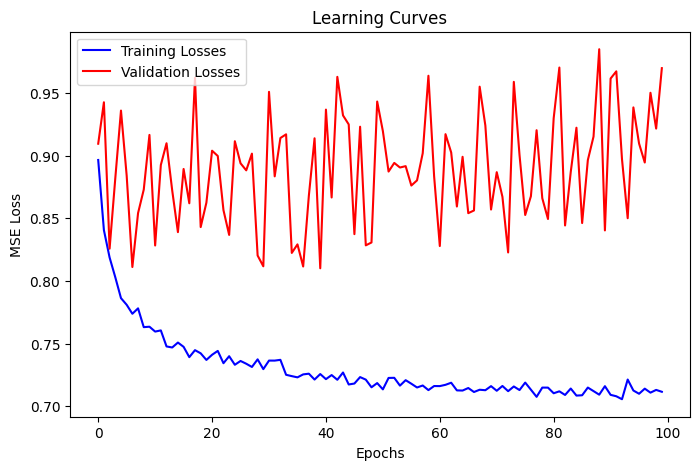

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(trainer.train_losses, color='blue', label='Training Losses')
ax.plot(trainer.val_losses, color='red', label='Validation Losses')
ax.legend()
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Learning Curves')
plt.show()

In [18]:
linear_regression_nn_trained = trainer.model

# Fully Connected Neural Network

## Model Definition

In [19]:
class CSOPFullyConnectedNN(nn.Module):
    def __init__(self, num_input_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=num_input_features, out_features=15),
            nn.ReLU(),
            nn.Linear(in_features=15, out_features=1)
        )

    def forward(self, X):
        return self.net(X)

In [20]:
fully_connected_nn = CSOPFullyConnectedNN(num_input_features=X_train.shape[1])

## Model Training Setup

In [21]:
loss_fn = nn.MSELoss()
learning_rate = 0.0001
optimizer = Adam(params=fully_connected_nn.parameters(), lr=learning_rate)
max_epochs = 100

In [22]:
best_mse = float('inf')
best_weights = None
train_losses, val_losses = [], []

## Model Training Loop

In [23]:
for epoch in range(max_epochs):
    # Training for one epoch
    fully_connected_nn.train()
    train_loss = 0
    with tqdm(list(range(len(train_dataloader))), unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f'Epoch: {epoch}')
        for (X_batch, y_batch), start in zip(train_dataloader, bar):
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = fully_connected_nn(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            # Weights Updates
            optimizer.step()
            # Print Progress
            bar.set_postfix(mse=float(loss))
            train_loss += float(loss)
    # Calculating average training loss after one epoch
    avg_train_mse_loss = float(train_loss/len(train_dataloader))
    train_losses.append(avg_train_mse_loss)
    # Validation after one epoch
    fully_connected_nn.eval()
    val_loss = 0
    for X_batch, y_batch in val_dataloader:
        # Forward Pass
        X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
        y_pred = fully_connected_nn(X_batch)
        val_mse_loss = loss_fn(y_pred, y_batch)
        val_loss += float(val_mse_loss)
    # Calculating average validation loss after one epoch
    avg_val_mse_loss = float(val_loss/len(val_dataloader))
    val_losses.append(avg_val_mse_loss)
    # Checking if we improved from the previous best epoch
    if avg_val_mse_loss < best_mse:
        best_mse = avg_val_mse_loss
        best_weights = copy.deepcopy(fully_connected_nn.state_dict())

Epoch: 99:  93%|█████████▎| 13/14 [00:00<00:00, 291.47batch/s, mse=0.804]


In [24]:
fully_connected_nn.load_state_dict(best_weights)
model_path = f'feature_bagging_nn_models/fully_connected_nn_best_model'
torch.save(fully_connected_nn.state_dict(), model_path)


Best Validation MSE: 0.7165828794240952


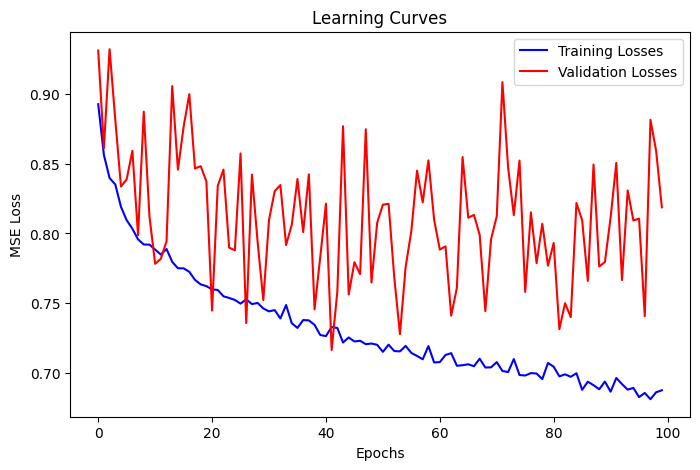

In [25]:
print(f'Best Validation MSE: {best_mse}')
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_losses, color='blue', label='Training Losses')
ax.plot(val_losses, color='red', label='Validation Losses')
ax.legend()
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Learning Curves')
plt.show()

In [26]:
def calc_nn_metrics(y_true, y_pred, type='TRAIN'):
    r2 = r2_score(y_true=y_true, y_pred=y_pred).round(4)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred).round(4)
    rmse = np.sqrt(mse).round(4)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred).round(4)

    print(f'{type} METRICS')
    print(f'R2: {r2}\tMSE: {mse}\tRMSE: {rmse}\tMAE: {mae}')

In [27]:
train_preds = fully_connected_nn(torch.tensor(X_train.to_numpy(), dtype=torch.float32)).detach().numpy()
val_preds = fully_connected_nn(torch.tensor(X_val.to_numpy(), dtype=torch.float32)).detach().numpy()

In [28]:
calc_nn_metrics(y_true=y_train, y_pred=train_preds, type='TRAIN')

TRAIN METRICS
R2: 0.2617	MSE: 0.7291	RMSE: 0.8539	MAE: 0.6202


In [29]:
calc_nn_metrics(y_true=y_val, y_pred=val_preds, type='VALIDATION')

VALIDATION METRICS
R2: 0.2705	MSE: 0.8046	RMSE: 0.897	MAE: 0.714


# Sparsely Connected Neural Network

## Data Prep

### Defining set of features

The following features are to be excluded (they are either not present in the feature groupings or in the training datasets)

In [30]:
for feature in X_train.columns:
    if feature not in feature_groupings['Feature Name'].to_list():
        print(feature)

incongruent_modulation
average_present_tense
variance_in_DD
min_present_tense
within_person_disc_range
max_present_tense
stdev_present_tense
discursive_diversity


In [31]:
for feature in feature_groupings['Feature Name'].to_list():
    if feature not in X_train.columns:
        print(feature)

min_dale_chall_classification
max_dale_chall_classification
stdev_dale_chall_classification
average_dale_chall_classification
min_time_diff
max_time_diff
stdev_time_diff
average_time_diff


In [32]:
feature_subset = list(set(X_train.columns).intersection(set(feature_groupings['Feature Name'].to_list())))
feature_subset.sort()

### Preparing Mask

In [33]:
feature_groupings_subset = feature_groupings[
    feature_groupings['Feature Name'].isin(feature_subset)
].drop_duplicates().sort_values(by=['Feature Name'])
mask = feature_groupings_subset.iloc[:, 1:].to_numpy()
mask.shape

(378, 15)

### Preparing Dataset

In [34]:
X_train_subset = X_train.loc[:, feature_subset]
X_val_subset = X_val.loc[:, feature_subset]
X_test_subset = X_test.loc[:, feature_subset]

train_dataset_subset = CSOPDataset(X=X_train_subset.to_numpy(), y=y_train.to_numpy())
val_dataset_subset = CSOPDataset(X=X_val_subset.to_numpy(), y=y_val.to_numpy())

train_dataloader_subset = DataLoader(dataset=train_dataset_subset, batch_size=64, shuffle=True)
val_dataloader_subset = DataLoader(dataset=val_dataset_subset, batch_size=64, shuffle=True)

## Model Definition

In [35]:
class MaskedLinear(nn.Linear):
    def __init__(self, mask, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mask = torch.tensor(mask, requires_grad=False, dtype=torch.float32)
    
    def forward(self, X):
        return F.linear(input=X, weight=self.weight, bias=self.bias)@self.mask

In [36]:
class CSOPSparselyConnectedNN(nn.Module):
    def __init__(self, num_input_features, mask, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = nn.Sequential(
            MaskedLinear(in_features=num_input_features, out_features=num_input_features, mask=mask),
            nn.ReLU(),
            nn.Linear(in_features=15, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=4),
            nn.ReLU(),
            nn.Linear(in_features=4, out_features=1)
        )

    def forward(self, X):
        return self.net(X)

In [37]:
sparsely_connected_nn = CSOPSparselyConnectedNN(num_input_features=X_train_subset.shape[1], mask=mask)

In [38]:
sparsely_connected_nn

CSOPSparselyConnectedNN(
  (net): Sequential(
    (0): MaskedLinear(in_features=378, out_features=378, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=1, bias=True)
  )
)

## Model Training Setup

In [39]:
loss_fn = nn.MSELoss()
learning_rate = 0.0001
optimizer = Adam(params=fully_connected_nn.parameters(), lr=learning_rate)
max_epochs = 100

best_mse = float('inf')
best_weights = None
train_losses, val_losses = [], []

## Model Training Loop

In [40]:
for epoch in range(max_epochs):
    # Training for one epoch
    sparsely_connected_nn.train()
    train_loss = 0
    with tqdm(list(range(len(train_dataloader_subset))), unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f'Epoch: {epoch}')
        for (X_batch, y_batch), start in zip(train_dataloader_subset, bar):
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = sparsely_connected_nn(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            # Weights Updates
            optimizer.step()
            # Print Progress
            bar.set_postfix(mse=float(loss))
            train_loss += float(loss)
    # Calculating average training loss after one epoch
    avg_train_mse_loss = float(train_loss/len(train_dataloader_subset))
    train_losses.append(avg_train_mse_loss)
    # Validation after one epoch
    sparsely_connected_nn.eval()
    val_loss = 0
    for X_batch, y_batch in val_dataloader_subset:
        # Forward Pass
        X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
        y_pred = sparsely_connected_nn(X_batch)
        val_mse_loss = loss_fn(y_pred, y_batch)
        val_loss += float(val_mse_loss)
    # Calculating average validation loss after one epoch
    avg_val_mse_loss = float(val_loss/len(val_dataloader_subset))
    val_losses.append(avg_val_mse_loss)
    # Checking if we improved from the previous best epoch
    if avg_val_mse_loss < best_mse:
        best_mse = avg_val_mse_loss
        best_weights = copy.deepcopy(sparsely_connected_nn.state_dict())

Epoch: 99:  93%|█████████▎| 13/14 [00:00<00:00, 204.79batch/s, mse=1.01] 


## Saving Best Model

In [41]:
sparsely_connected_nn.load_state_dict(best_weights)
model_path = f'feature_bagging_nn_models/sparsely_connected_nn_best_model'
torch.save(sparsely_connected_nn.state_dict(), model_path)

## Learning Curves

Best Validation MSE: 1.105033278465271


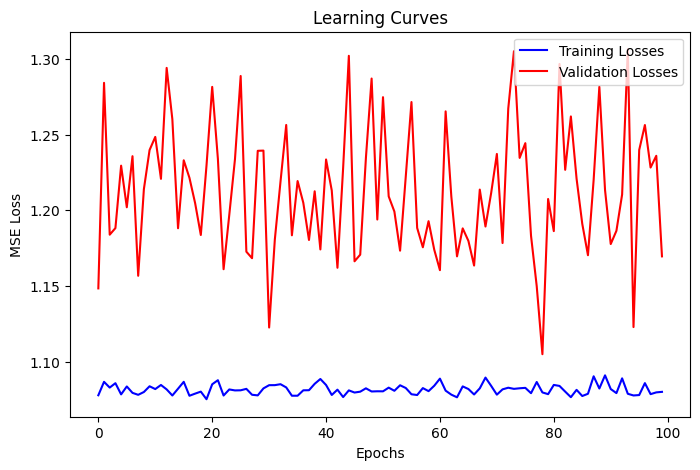

In [42]:
print(f'Best Validation MSE: {best_mse}')
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_losses, color='blue', label='Training Losses')
ax.plot(val_losses, color='red', label='Validation Losses')
ax.legend()
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Learning Curves')
plt.show()

## Metrics

In [43]:
train_preds = sparsely_connected_nn(torch.tensor(X_train_subset.to_numpy(), dtype=torch.float32)).detach().numpy()
val_preds = sparsely_connected_nn(torch.tensor(X_val_subset.to_numpy(), dtype=torch.float32)).detach().numpy()

In [44]:
calc_nn_metrics(y_true=y_train, y_pred=train_preds, type='TRAIN')

TRAIN METRICS
R2: -0.0948	MSE: 1.0813	RMSE: 1.0399	MAE: 0.868


In [45]:
calc_nn_metrics(y_true=y_val, y_pred=val_preds, type='VALIDATION')

VALIDATION METRICS
R2: -0.1059	MSE: 1.2198	RMSE: 1.1044	MAE: 0.9363


# Sparsely Connected Neural Network V2

## Data Prep

### Defining set of features

The following features are to be excluded (they are either not present in the feature groupings or in the training datasets)

In [46]:
for feature in X_train.columns:
    if feature not in feature_groupings['Feature Name'].to_list():
        print(feature)

incongruent_modulation
average_present_tense
variance_in_DD
min_present_tense
within_person_disc_range
max_present_tense
stdev_present_tense
discursive_diversity


In [47]:
for feature in feature_groupings['Feature Name'].to_list():
    if feature not in X_train.columns:
        print(feature)

min_dale_chall_classification
max_dale_chall_classification
stdev_dale_chall_classification
average_dale_chall_classification
min_time_diff
max_time_diff
stdev_time_diff
average_time_diff


In [48]:
feature_subset = list(set(X_train.columns).intersection(set(feature_groupings['Feature Name'].to_list())))
feature_subset.sort()

### Preparing Mask

In [49]:
feature_groupings_subset = feature_groupings[
    feature_groupings['Feature Name'].isin(feature_subset)
].drop_duplicates().sort_values(by=['Feature Name'])
mask = feature_groupings_subset.iloc[:, 1:].to_numpy().T
mask.shape

(15, 378)

### Preparing Dataset

In [50]:
X_train_subset = X_train.loc[:, feature_subset]
X_val_subset = X_val.loc[:, feature_subset]
X_test_subset = X_test.loc[:, feature_subset]

train_dataset_subset = CSOPDataset(X=X_train_subset.to_numpy(), y=y_train.to_numpy())
val_dataset_subset = CSOPDataset(X=X_val_subset.to_numpy(), y=y_val.to_numpy())

train_dataloader_subset = DataLoader(dataset=train_dataset_subset, batch_size=64, shuffle=True)
val_dataloader_subset = DataLoader(dataset=val_dataset_subset, batch_size=64, shuffle=True)

## Model Definition

In [51]:
class CSOPSparselyConnectedNNV2(nn.Module):
    def __init__(self, num_input_features, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = nn.Sequential(
            nn.Linear(in_features=num_input_features, out_features=15),
            nn.ReLU(),
            nn.Linear(in_features=15, out_features=1)
        )

    def forward(self, X):
        return self.net(X)

In [52]:
sparsely_connected_nn_v2 = CSOPSparselyConnectedNNV2(num_input_features=X_train_subset.shape[1])

In [53]:
# temp = sparsely_connected_nn_v2.net[0].weight
# sparsely_connected_nn_v2.net[0].weight = torch.nn.Parameter(torch.FloatTensor(temp.detach().numpy() * mask))

## Model Training Setup

In [54]:
loss_fn = nn.MSELoss()
learning_rate = 0.0001
optimizer = Adam(params=fully_connected_nn.parameters(), lr=learning_rate)
max_epochs = 100

best_mse = float('inf')
best_weights = None
train_losses, val_losses = [], []

## Model Training Loop

In [55]:
for epoch in range(max_epochs):
    # Training for one epoch
    sparsely_connected_nn_v2.train()
    train_loss = 0
    with tqdm(list(range(len(train_dataloader_subset))), unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f'Epoch: {epoch}')
        for (X_batch, y_batch), start in zip(train_dataloader_subset, bar):
            # Make sure mask is applied before forward pass
            init_weight = sparsely_connected_nn_v2.net[0].weight.detach().numpy()
            sparsely_connected_nn_v2.net[0].weight = torch.nn.Parameter(torch.FloatTensor(init_weight * mask))
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = sparsely_connected_nn_v2(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            # Weights Updates
            optimizer.step()
            # Make sure mask is applied after the optimizer performs gradient descent
            init_weight = sparsely_connected_nn_v2.net[0].weight.detach().numpy()
            sparsely_connected_nn_v2.net[0].weight = torch.nn.Parameter(torch.FloatTensor(init_weight * mask))
            # Print Progress
            bar.set_postfix(mse=float(loss))
            train_loss += float(loss)
    # Calculating average training loss after one epoch
    avg_train_mse_loss = float(train_loss/len(train_dataloader_subset))
    train_losses.append(avg_train_mse_loss)
    # Validation after one epoch
    sparsely_connected_nn_v2.eval()
    val_loss = 0
    for X_batch, y_batch in val_dataloader_subset:
        # Forward Pass
        X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
        y_pred = sparsely_connected_nn_v2(X_batch)
        val_mse_loss = loss_fn(y_pred, y_batch)
        val_loss += float(val_mse_loss)
    # Calculating average validation loss after one epoch
    avg_val_mse_loss = float(val_loss/len(val_dataloader_subset))
    val_losses.append(avg_val_mse_loss)
    # Checking if we improved from the previous best epoch
    if avg_val_mse_loss < best_mse:
        best_mse = avg_val_mse_loss
        best_weights = copy.deepcopy(sparsely_connected_nn_v2.state_dict())

Epoch: 99:  93%|█████████▎| 13/14 [00:00<00:00, 281.76batch/s, mse=0.904]


## Saving Best Model

In [56]:
sparsely_connected_nn_v2.load_state_dict(best_weights)
model_path = f'feature_bagging_nn_models/sparsely_connected_nn_v2_best_model'
torch.save(sparsely_connected_nn_v2.state_dict(), model_path)

## Learning Curves

Best Validation MSE: 0.9160647541284561


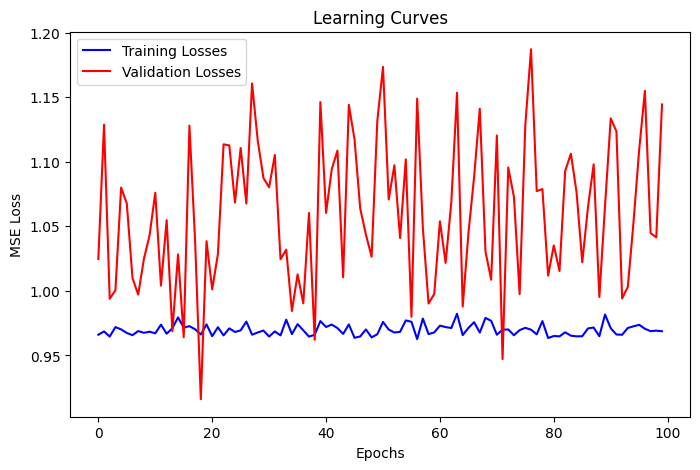

In [57]:
print(f'Best Validation MSE: {best_mse}')
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_losses, color='blue', label='Training Losses')
ax.plot(val_losses, color='red', label='Validation Losses')
ax.legend()
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Learning Curves')
plt.show()

## Metrics

In [58]:
train_preds = sparsely_connected_nn_v2(torch.tensor(X_train_subset.to_numpy(), dtype=torch.float32)).detach().numpy()
val_preds = sparsely_connected_nn_v2(torch.tensor(X_val_subset.to_numpy(), dtype=torch.float32)).detach().numpy()

In [59]:
calc_nn_metrics(y_true=y_train, y_pred=train_preds, type='TRAIN')

TRAIN METRICS
R2: 0.0181	MSE: 0.9698	RMSE: 0.9848	MAE: 0.748


In [60]:
calc_nn_metrics(y_true=y_val, y_pred=val_preds, type='VALIDATION')

VALIDATION METRICS
R2: 0.031	MSE: 1.0689	RMSE: 1.0339	MAE: 0.8189
